# Working with Polytopes: Union and Visualization

This notebook demonstrates how to:
1. Create polytopes using the `polytope` library
2. Find the union of multiple polytopes
3. Convert polytopes to intervals for visualization
4. Plot the results using matplotlib

In [ ]:
# Function to extract interval bounds from a polytope
def get_interval_bounds(poly):
    # For 1D polytopes, the bounds are simply the min and max values
    # that satisfy the constraints Ax <= b
    A, b = poly.A, poly.b
    bounds = []
    for i in range(0, len(b), 2):
        lower = -b[i]  # Since we have -1*x <= -lower
        upper = b[i+1]  # Since we have 1*x <= upper
        bounds.append((lower, upper))
    return bounds

# Function to merge overlapping intervals
def merge_intervals(intervals):
    if not intervals:
        return []
    
    # Sort intervals by start time
    sorted_intervals = sorted(intervals, key=lambda x: x[0])
    
    merged = [sorted_intervals[0]]
    
    for interval in sorted_intervals[1:]:
        if interval[0] <= merged[-1][1]:
            # Intervals overlap, update the end time
            merged[-1] = (merged[-1][0], max(merged[-1][1], interval[1]))
        else:
            # No overlap, add new interval
            merged.append(interval)
            
    return merged

# Get intervals from polytopes
polytopes = [poly1, poly2, poly3]
intervals = []
for poly in polytopes:
    intervals.extend(get_interval_bounds(poly))

# Merge overlapping intervals
merged_intervals = merge_intervals(intervals)

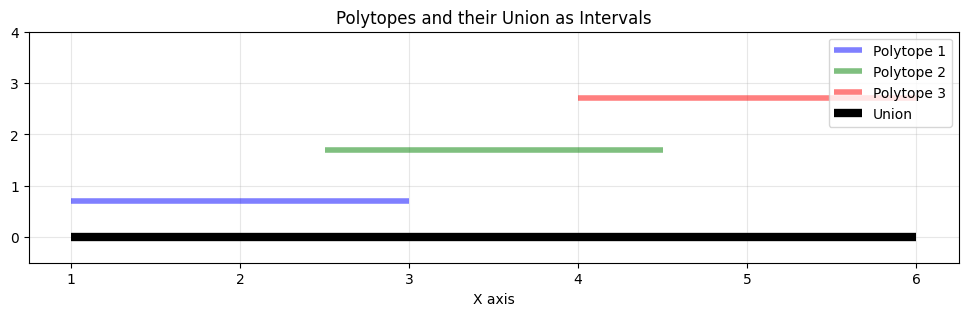

In [7]:
# Plotting
plt.figure(figsize=(12, 3))

# Plot original polytopes
colors = ['blue', 'green', 'red']
for i, poly in enumerate(polytopes):
    bounds = get_interval_bounds(poly)[0]
    plt.hlines(y=i+0.7, xmin=bounds[0], xmax=bounds[1], color=colors[i], 
              label=f'Polytope {i+1}', linewidth=4, alpha=0.5)

# Plot merged intervals
for i, interval in enumerate(merged_intervals):
    plt.hlines(y=0, xmin=interval[0], xmax=interval[1], color='black', 
              linewidth=6, label='Union' if i == 0 else '')

plt.ylim(-0.5, 4)
plt.xlabel('X axis')
plt.title('Polytopes and their Union as Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
%pip install polytope
import polytope as pc
import matplotlib.pyplot as plt    
from scipy.spatial import ConvexHull
import numpy as np


# Define two example polytopes
# Polytope 1 (a square)
A1 = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b1 = np.array([1, 1, 1, 1])
p1 = pc.Polytope(A1, b1)

# Polytope 2 (a triangle)
A2 = np.array([[1, 0], [0, 1], [-1, -1]])
b2 = np.array([2, 2, -1])
p2 = pc.Polytope(A2, b2)

# Get the vertices of each polytope
vertices1 = p1.V
vertices2 = p2.V

# Combine the vertices
combined_vertices = np.vstack((vertices1, vertices2))

# Compute the convex hull of the combined vertices
hull = ConvexHull(combined_vertices)

# The vertices of the convex hull represent the "union" in a convex sense
# You can then construct a new Polytope from these hull vertices if needed
# (Note: pc.Polytope typically takes A and b matrices, so converting from vertices
# to H-representation might be required for a direct Polytope object)
print("Vertices of the convex hull (representing the union):")
print(combined_vertices[hull.vertices])

fig, ax = plt.subplots()

# Plot Polytope 1
p1.plot(ax, color='red', alpha=0.5, label='Polytope 1')

# Plot Polytope 2
p2.plot(ax, color='blue', alpha=0.5, label='Polytope 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Union of Polytopes')
ax.legend()
ax.grid(True)
plt.show()

Note: you may need to restart the kernel to use updated packages.


AttributeError: 'Polytope' object has no attribute 'V'

In [ ]:
# GPU Acceleration Example
import cupy as cp  # For GPU acceleration
import numpy as np
import time

def gpu_accelerated_preprocessing(system_matrices, num_iterations):
    """
    Example of GPU-accelerated matrix operations for system analysis
    """
    # Move data to GPU
    A_gpu = cp.array(system_matrices['A'])
    B_gpu = cp.array(system_matrices['B'])
    
    # Perform operations on GPU
    start_time = time.time()
    for _ in range(num_iterations):
        # Example: Computing reachable states
        result = cp.matmul(A_gpu, B_gpu)
        
    # Move result back to CPU
    result_cpu = cp.asnumpy(result)
    end_time = time.time()
    
    print(f"GPU computation time: {end_time - start_time:.4f} seconds")
    return result_cpu

# Example usage
if __name__ == "__main__":
    # Sample system matrices
    A = np.random.rand(1000, 1000)
    B = np.random.rand(1000, 100)
    
    system_matrices = {'A': A, 'B': B}
    result = gpu_accelerated_preprocessing(system_matrices, 100)

In [ ]:
# Required Libraries
import numpy as np
import scipy.io as sio
from pathlib import Path
import re
import sympy as sp
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Union
import matlab.engine  # For direct MATLAB integration
# Data Classes for System Components
@dataclass
class StateVariable:
    name: str
    initial_range: Tuple[float, float]
    unsafe_range: Optional[Tuple[float, float]] = None
    
@dataclass
class SystemParameters:
    name: str
    A: np.ndarray  # System matrix
    B: np.ndarray  # Input matrix
    C: np.ndarray  # Output matrix
    D: np.ndarray  # Feedthrough matrix
    state_vars: List[StateVariable]
    sampling_time: float
    max_time: float
    
@dataclass
class Guard:
    condition: str
    from_mode: str
    to_mode: str
    reset: Dict[str, str]
    
@dataclass
class Mode:
    name: str
    dynamics: Dict[str, str]
    invariants: List[str]

In [ ]:
def parse_matlab_model(file_path: str) -> SystemParameters:
    """
    Parse MATLAB model file and extract system parameters
    
    Args:
        file_path: Path to .m or .mat file
        
    Returns:
        SystemParameters object containing model information
    """
    # Initialize MATLAB engine
    eng = matlab.engine.start_matlab()
    
    try:
        if file_path.endswith('.mat'):
            # Load .mat file
            mat_contents = sio.loadmat(file_path)
            A = mat_contents.get('A', None)
            B = mat_contents.get('B', None)
            C = mat_contents.get('C', None)
            D = mat_contents.get('D', None)
        else:
            # Execute .m file
            eng.addpath(str(Path(file_path).parent))
            eng.run(str(Path(file_path).stem), nargout=0)
            
            # Get variables from MATLAB workspace
            A = np.array(eng.workspace['A'])
            B = np.array(eng.workspace['B'])
            C = np.array(eng.workspace['C'])
            D = np.array(eng.workspace['D'])
            
        # Extract state variable names if available
        state_vars = []
        n_states = A.shape[0]
        for i in range(n_states):
            state_vars.append(StateVariable(
                name=f'x{i+1}',
                initial_range=(-1.0, 1.0)  # Default range
            ))
            
        return SystemParameters(
            name=Path(file_path).stem,
            A=A, B=B, C=C, D=D,
            state_vars=state_vars,
            sampling_time=0.01,  # Default sampling time
            max_time=1.0  # Default max time
        )
        
    finally:
        eng.quit()

In [ ]:
def generate_dynamics_equations(system: SystemParameters) -> Dict[str, str]:
    """
    Generate symbolic equations for system dynamics
    """
    dynamics = {}
    x = sp.Matrix(sp.symbols(f'x1:{len(system.state_vars)+1}'))
    
    # Convert numpy arrays to symbolic matrices
    A = sp.Matrix(system.A)
    
    # Generate dynamics equations
    dx = A * x
    
    for i, state_var in enumerate(system.state_vars):
        dynamics[f"{state_var.name}'"] = str(dx[i])
        
    return dynamics

def generate_mode(name: str, dynamics: Dict[str, str], invariants: List[str]) -> str:
    """
    Generate FlowStar mode description
    """
    mode_str = f"  {name}\n  {{\n   poly ode 1\n   {{\n"
    
    # Add dynamics equations
    for var, eq in dynamics.items():
        mode_str += f"    {var} = {eq}\n"
    
    mode_str += "   }\n   inv\n   {\n"
    
    # Add invariants
    for inv in invariants:
        mode_str += f"    {inv}\n"
    
    mode_str += "   }\n  }\n"
    
    return mode_str

In [ ]:
def generate_flowstar_model(system: SystemParameters, 
                          modes: List[Mode],
                          guards: List[Guard]) -> str:
    """
    Generate complete FlowStar model file content
    """
    model = f"hybrid reachability\n{{\n"
    
    # State variables declaration
    state_vars = [var.name for var in system.state_vars]
    model += f" state var {', '.join(state_vars)}\n\n"
    
    # Parameters section
    model += " setting\n {\n"
    model += f"  fixed steps {system.sampling_time}\n"
    model += f"  time {system.max_time}\n"
    model += "  remainder estimation 1e-3\n"
    model += "  identity precondition\n"
    model += f"  output {system.name}\n"
    model += "  max jumps 100\n"
    model += "  print on\n }\n\n"
    
    # Modes section
    model += " modes\n {\n"
    for mode in modes:
        model += generate_mode(mode.name, mode.dynamics, mode.invariants)
    model += " }\n\n"
    
    # Jumps section
    model += " jumps\n {\n"
    for guard in guards:
        model += generate_guard(guard)
    model += " }\n\n"
    
    # Initial conditions
    model += " init\n {\n"
    model += "  l1\n  {\n"
    for var in system.state_vars:
        model += f"   {var.name} in [{var.initial_range[0]},{var.initial_range[1]}]\n"
    model += "  }\n }\n"
    
    # Unsafe conditions
    model += "}\n\nunsafe\n{\n"
    for mode in modes:
        model += f"  {mode.name}\n  {{\n"
        for var in system.state_vars:
            if var.unsafe_range:
                model += f"   {var.name} >= {var.unsafe_range[1]}  {var.name} <= {var.unsafe_range[0]}\n"
        model += "  }\n"
    model += "}"
    
    return model

def generate_guard(guard: Guard) -> str:
    """
    Generate FlowStar guard description
    """
    guard_str = f"  {guard.from_mode} -> {guard.to_mode}\n"
    guard_str += f"  guard {{ {guard.condition} }}\n"
    guard_str += "  reset {\n"
    for var, reset in guard.reset.items():
        guard_str += f"    {var}' := {reset}\n"
    guard_str += "  }\n"
    return guard_str

# Example Usage

Let's demonstrate how to use this converter with a sample MATLAB system model.

In [ ]:
# Example usage with a sample system
def example_conversion():
    # Sample system parameters (normally these would come from MATLAB file)
    A = np.array([
        [0.995860265603438, 0.0378696105301410],
        [-0.174562623798343, 0.908578953704267]
    ])
    B = np.array([[1.0], [0.5]])
    C = np.eye(2)
    D = np.zeros((2, 1))
    
    # Create state variables
    state_vars = [
        StateVariable(
            name='x1',
            initial_range=(-1, 1),
            unsafe_range=(-2, 2)
        ),
        StateVariable(
            name='x2',
            initial_range=(-100, 100),
            unsafe_range=(-200, 200)
        )
    ]
    
    # Create system parameters
    system = SystemParameters(
        name="sample_system",
        A=A, B=B, C=C, D=D,
        state_vars=state_vars,
        sampling_time=0.01,
        max_time=1.0
    )
    
    # Generate dynamics
    dynamics = generate_dynamics_equations(system)
    
    # Create modes
    modes = [
        Mode(
            name="l1",
            dynamics=dynamics,
            invariants=["length <= 20", "missct <= 10"]
        )
    ]
    
    # Create guards
    guards = [
        Guard(
            from_mode="l1",
            to_mode="l1",
            condition="length + 1 <= 20 and missct <= 10 and dt = 0.04",
            reset={
                "x1": "0.242485063948108*x1 + 0.019880697758022*x2",
                "x2": "-4.966153983486504*x1 + 0.236421716395938*x2"
            }
        )
    ]
    
    # Generate FlowStar model
    model_content = generate_flowstar_model(system, modes, guards)
    
    # Save to file
    output_path = "models/sample_system.model"
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, "w") as f:
        f.write(model_content)
    
    return model_content

# Run the example
model_content = example_conversion()
print("Generated model content:")
print(model_content)

In [ ]:
def generate_specialized_model(
    mat_file: str,
    output_prefix: str,
    h: float,  # sampling time
    mdadt1: int,  # MDADT parameter for location 1
    Kmax_values: List[int],  # List of maximum length parameters to try
    mmax_values: List[int],  # List of maximum miss counts to try
    init_ranges: List[List[Tuple[float, float]]]  # List of initial condition ranges for state variables
) -> None:
    """
    Generate specialized FlowStar model files with different parameters and initial conditions.
    
    Args:
        mat_file: Path to .mat file containing system matrices
        output_prefix: Prefix for output model files
        h: Sampling time
        mdadt1: MDADT parameter for location 1
        Kmax_values: List of K_max values to try
        mmax_values: List of m_max values to try
        init_ranges: List of initial condition ranges for different configurations
    """
    # Load system matrices from .mat file
    mat_data = sio.loadmat(mat_file)
    A = mat_data['A']
    B = mat_data['B']
    C = mat_data['C']
    D = mat_data.get('D', np.zeros((C.shape[0], B.shape[1])))
    
    n_states = A.shape[0]  # Number of physical states
    n_total = 2 * n_states  # Including estimated states
    
    # Generate models for each combination
    for Kmax in Kmax_values:
        for mmax in mmax_values:
            for init_idx, init_range in enumerate(init_ranges):
                model_content = []
                
                # File name encoding parameters
                file_name = f"{output_prefix}_K{Kmax}_M{mmax}_I{init_idx}.model"
                
                # Header
                model_content.append("hybrid reachability\n{")
                
                # State variables
                states = [f"x{i+1}" for i in range(n_states)]  # Physical states
                est_states = [f"x{i+1}_hat" for i in range(n_states)]  # Estimated states
                model_content.append(f" state var {', '.join(states + est_states)}, dt, gt, length, missct")
                
                # Parameters section
                model_content.append(f"\n par\n {{")
                model_content.append(f"  Kmax = {Kmax}  mmax = {mmax}  h = {h}  mdadt1 = {mdadt1}")
                
                # Add system matrices as parameters
                for i in range(n_states):
                    for j in range(n_states):
                        model_content.append(f"  a{i+1}{j+1} = {A[i,j]}")
                # Add B, C matrices similarly
                model_content.append(" }")

                # Settings
                model_content.extend([
                    "\n setting",
                    " {",
                    f"  fixed steps {h/10}",  # Smaller steps for accurate simulation
                    f"  time {Kmax * h}",
                    "  remainder estimation 1e-3",
                    "  identity precondition",
                    f"  gnuplot octagon gt, x1",
                    "  fixed orders 12",
                    "  cutoff 1e-8",
                    "  precision 53",
                    f"  output {output_prefix}_K{Kmax}_M{mmax}_I{init_idx}",
                    f"  max jumps {Kmax * 2}",
                    "  print on",
                    " }\n"
                ])

In [ ]:
                # Generate modes
                model_content.append(" modes\n {")
                
                # Initial mode l0 with zero dynamics
                model_content.extend([
                    "  l0",
                    "  {",
                    "   poly ode 1",
                    "   {",
                    *[f"    {var}' = 0" for var in states + est_states],
                    "    dt' = 0",
                    "    gt' = 1",
                    "    length' = 0",
                    "    missct' = 0",
                    "   }",
                    "   inv",
                    "   {",
                    "    gt = 0",
                    "   }",
                    "  }"
                ])
                
                # Mode l1 (successful update)
                model_content.extend([
                    "\n  l1",
                    "  {",
                    "   poly ode 1",
                    "   {",
                    *generate_continuous_dynamics(A, B, K, states, est_states),
                    "    dt' = h",
                    "    gt' = 1",
                    "    length' = 0",
                    "    missct' = 0",
                    "   }",
                    "   inv",
                    "   {",
                    "    length <= Kmax",
                    "    missct <= mmax",
                    "   }",
                    "  }"
                ])
                
                # Mode l1dt (MDADT handling)
                model_content.extend([
                    "\n  l1dt",
                    "  {",
                    "   poly ode 1",
                    "   {",
                    *generate_continuous_dynamics(A, B, K, states, est_states),
                    "    dt' = h",
                    "    gt' = 1",
                    "    length' = 0",
                    "    missct' = 0",
                    "   }",
                    "   inv",
                    "   {",
                    "    length <= Kmax",
                    "    missct <= mmax",
                    "   }",
                    "  }"
                ])
                
                # Generate l10, l100, etc. modes for missed updates
                for i in range(1, min(mmax + 1, Kmax)):
                    mode_name = f"l{'1' + '0' * i}"
                    model_content.extend([
                        f"\n  {mode_name}",
                        "  {",
                        "   poly ode 1",
                        "   {",
                        *generate_continuous_dynamics(A, B, K, states, est_states),
                        "    dt' = h",
                        "    gt' = 1",
                        "    length' = 0",
                        "    missct' = 0",
                        "   }",
                        "   inv",
                        "   {",
                        "    length <= Kmax",
                        "    missct <= mmax",
                        "   }",
                        "  }"
                    ])

In [ ]:
                # Generate jumps
                model_content.append("\n jumps\n {")
                
                # Jumps from l0 to other modes
                for i in range(min(mmax + 1, Kmax)):
                    mode_name = f"l{'1' + '0' * i}"
                    model_content.extend([
                        f"  l0 -> {mode_name}",
                        "  guard { gt = 0 }",
                        "  reset {",
                        *generate_state_resets(A, B, K, states, est_states),
                        f"    length' := {i + 1}",
                        f"    missct' := {i}",
                        "    dt' := 0",
                        "  }",
                        "  interval aggregation\n"
                    ])
                
                # Jumps from l1 (successful update)
                for i in range(min(mmax + 1, Kmax)):
                    mode_name = f"l{'1' + '0' * i}"
                    model_content.extend([
                        f"  l1 -> {mode_name}",
                        f"  guard {{ length + {i + 1} <= Kmax  missct + {i} <= mmax  dt = h }}",
                        "  reset {",
                        *generate_state_resets(A, B, K, states, est_states),
                        f"    length' := length + {i + 1}",
                        f"    missct' := missct + {i}",
                        "    dt' := 0",
                        "  }",
                        "  interval aggregation\n"
                    ])
                
                # Jumps for l1dt (MDADT handling)
                model_content.extend([
                    "  l1dt -> l1dt",
                    f"  guard {{ dt = h  gt <= {mdadt1 * h} }}",
                    "  reset {",
                    *generate_state_resets(A, B, K, states, est_states),
                    "    length' := length",
                    "    missct' := missct",
                    "    dt' := 0",
                    "  }",
                    "  interval aggregation\n"
                ])
                
                # Generate init section
                model_content.append("\n init\n {")
                model_content.append("  l0\n  {")
                for i, (min_val, max_val) in enumerate(init_range):
                    model_content.append(f"   x{i+1} in [{min_val},{max_val}]")
                    model_content.append(f"   x{i+1}_hat in [{min_val},{max_val}]")
                model_content.extend([
                    "   dt in [0,0]",
                    "   gt in [0,0]",
                    "   length in [0,0]",
                    "   missct in [0,0]",
                    "  }",
                    " }"
                ])
                
                # Generate unsafe section
                model_content.append("\nunsafe\n{")
                for mode in ["l1", "l1dt"] + [f"l{'1' + '0' * i}" for i in range(1, min(mmax + 1, Kmax))]:
                    model_content.append(f"  {mode}")
                    model_content.append("  {")
                    for i in range(n_states):
                        unsafe_range = [-2, 2]  # Example unsafe ranges, adjust as needed
                        model_content.append(f"    x{i+1} >= {unsafe_range[1]}  x{i+1} <= {unsafe_range[0]}")
                    model_content.append("  }")
                model_content.append("}")
                
                # Write to file
                with open(file_name, 'w') as f:
                    f.write('\n'.join(model_content))
                
def generate_continuous_dynamics(A, B, K, states, est_states):
    """Generate continuous dynamics equations"""
    n_states = A.shape[0]
    dynamics = []
    
    # Physical states
    for i in range(n_states):
        eq = [f"{A[i,j]}*{states[j]}" for j in range(n_states)]
        est_terms = [f"{-B[i,0]*K[0,j]}*{est_states[j]}" for j in range(n_states)]
        dynamics.append(f"    {states[i]}' = {' + '.join(eq + est_terms)}")
    
    # Estimated states
    for i in range(n_states):
        dynamics.append(f"    {est_states[i]}' = 0")
        
    return dynamics

def generate_state_resets(A, B, K, states, est_states):
    """Generate reset equations for state updates"""
    n_states = A.shape[0]
    resets = []
    
    # Reset estimated states based on current physical states
    for i in range(n_states):
        eq = [f"{A[i,j]}*{est_states[j]}" for j in range(n_states)]
        state_terms = [f"{B[i,0]}*{states[0]}"]  # Assuming single input
        resets.append(f"    {est_states[i]}' := {' + '.join(eq + state_terms)}")
        
    return resets

In [ ]:
# Example usage
if __name__ == "__main__":
    # Example parameters
    mat_file = "models/system_with_noise.mat"
    output_prefix = "models/sus_ctrl/SUS"
    h = 0.04  # sampling time
    mdadt1 = 4  # MDADT parameter
    
    # Parameters to try
    Kmax_values = [10, 15, 20]
    mmax_values = [5, 8, 10]
    
    # Different initial conditions to try
    init_ranges = [
        [(-1, 1), (-100, 100), (-50, 50), (-300, 300)],  # First configuration
        [(-0.5, 0.5), (-50, 50), (-25, 25), (-150, 150)],  # Second configuration
        [(-2, 2), (-200, 200), (-100, 100), (-600, 600)]   # Third configuration
    ]
    
    # Generate all model files
    generate_specialized_model(
        mat_file=mat_file,
        output_prefix=output_prefix,
        h=h,
        mdadt1=mdadt1,
        Kmax_values=Kmax_values,
        mmax_values=mmax_values,
        init_ranges=init_ranges
    )
    
    print("Model files generated successfully!")

# Akash's Code

In [ ]:
%pip install polytope
import numpy as np
import itertools
from polytope import Polytope


def generate_model(A, B, C, Ad, Bd, K, L, h, safex, x0_bounds, filename, mdadt1=4, i=4, Kmax=20, mmax=10):
    """
    Generate Flow* .model file for suspension system with arbitrary locations.

    """
    
    fixed_step = 0.0001
    rem = 1e-3  # remainder estimation
    cutoff = 1e-8  # cutoff for polynomial terms
    prec = 53  # precision
    orders = [18, 30]  # fixed orders for Taylor model
    n = A.shape[0]  # number of states
    p = K.shape[0]  # number of inputs
    m = C.shape[0]  # number of outputs
    # ----------------define locations and their properties: length, miss count, sampling period---------------- ##
    locations = [10**j for j in range(i)]  # e.g. i=4 -> [1, 10, 100, 1000]
    all_locs = ['0'] + [str(loc) for loc in locations] + ['1'*mdadt1] + ['end'] # adding start, end, mdadt locations
    # Calculate length and misscount for each location
    loc_properties = {}
    for loc in all_locs:
        if loc == '0':
            loc_properties[loc] = {
                'length': 0,
                'missct': 0,
                'h_var': 'h0',  # no timing parameter
                'h_val': 0  # timing parameter value
            }
        elif loc == 'end':
            loc_properties[loc] = {
                'length': Kmax,
                'missct': mmax,
                'h_var': 'h0',  # no timing parameter
                'h_val': 0  # timing parameter value
            }
        elif loc == '1'*mdadt1:
            loc_properties[loc] = {
                'length': mdadt1,  
                'missct': 0,  # no misses to add
                'h_var': f"h",  # same timing parameter as 1 for MDADT 1
                'h_val': h  # timing parameter value
            }
        else:
            digits = len(loc)
            loc_properties[loc] = {
                'length': digits,  # number of steps to add
                'missct': digits-1,  # number of misses to add
                'h_var': f"h" if loc == '1' else f"h{loc}",  # timing parameter name
                'h_val': h if loc == '1' else h*digits  # timing parameter value
        }

    ## ---------Precompute (A - BK - LC), (Ad - BdK - LC) for dynamics---------- ##
    BK = B @ K.reshape(1,-1)
    LC = L @ C.reshape(1,-1)
    Acl = A - BK - LC

    BdK = Bd @ K.reshape(1,-1)
    Adcl = Ad - BdK - LC
    
    #### -----------Build file-------------- ####
    modelfile = f"{filename}.model"
    with open(modelfile, "w") as f:
        f.write("hybrid reachability\n{\n")
        
        # -------------Declare variables------------- #
        f.write(" state var " + ", ".join([f"x{j+1}" for j in range(n)]) + ", ")
        f.write(", ".join([f"x{j+1}_hat" for j in range(n)]) + ", dt, gt, length, missct, mdadt\n\n")

        # -------------Parameters------------- #
        f.write(" par\n {\n")
        
        # Write matrix A coefficients
        # for i in range(n):
        #     for j in range(n):
        #         f.write(f"  a{i+1}{j+1} = {A[i,j]}  ")
        #     # f.write("\n")
        # # Write matrix B coefficients
        # for i in range(n):
        #     for j in range(p):
        #         f.write(f"  b{i+1}{j+1} = {B[i,j]}  ")
        # # f.write("\n")
        # # Write matrix C coefficients
        # for i in range(m):
        #     for j in range(n):
        #         f.write(f"  c{i+1}{j+1} = {C[i,j]}  ")
        # # f.write("\n")
        # # Write Ad coefficients as ad (discrete A) matrix
        # for i in range(n):
        #     for j in range(n):
        #         f.write(f"  ad{i+1}{j+1} = {Acl[i,j]}  ")
        # # f.write("\n")
        # # Write Bd coefficients
        # for i in range(n):
        #     for j in range(p):
        #         f.write(f"  bd{i+1}{j+1} = {B[i,j]}  ")
        # # f.write("\n")
        # # Write K and L coefficients
        # for i in range(p):
        #     for j in range(n):
        #         f.write(f"  k{i+1}{j+1} = {K[i,j]}  ")
        # # f.write("\n")
        # for i in range(n):
        #     for j in range(m):
        #         f.write(f"  l{i+1}{j+1} = {L[i,j]}  ")
        # f.write("\n")
        
        f.write(f"  Kmax = {Kmax}   mmax = {mmax}   mdadt1 = {mdadt1}\n")
                
        # create timing parameters for each location
        timing_params = []
        for loc in all_locs:
            if loc > '0' and loc != '1'*mdadt1 and loc != 'end':  # skip l0, l1's mdadt variant
                timing_params.append(f"{loc_properties[loc]['h_var']} = {loc_properties[loc]['h_val']}")
        f.write("  " + "  ".join(timing_params) + "\n")
        f.write(" }\n\n")

        # ----------------Settings---------------- #
        f.write(" setting\n {\n")
        f.write(f"  fixed steps {str(fixed_step)}\n")
        f.write(f"  time {str(Kmax*h)}\n")
        f.write(f"  remainder estimation {str(rem)}\n")
        f.write("  identity precondition\n")
        f.write("  matlab octagon gt , x1\n")
        if len(orders) == 2:
            f.write(f"  adaptive orders {{ min {str(orders[0])} , max {str(orders[1])} }}\n")
        if len(orders) == 1:
            f.write(f"  fixed orders {str(orders)}\n")
        f.write(f"  cutoff {str(cutoff)}\n")
        f.write(f"  precision {str(prec)}\n")
        f.write(f"  output {os.path.basename(filename)}_op\n")
        f.write(f"  max jumps {Kmax}\n")
        f.write("  print on\n")
        f.write(" }\n\n")

        # ----------------locations---------------- #
        f.write(" modes\n {\n")
        
        for loc in all_locs:
            f.write(f"  l{loc}\n  {{\n")
             # --------------------- flow --------------------- #
            f.write("   poly ode 1\n   {\n")
            # x dynamics
            if loc > '0' and loc != 'end':  # not l0 or lend
                for j in range(n):
                    rhs = " + ".join([f"{A[j,k]}*x{k+1}" for k in range(n)])
                    rhs += " - (" + " + ".join([f"{BK[j,k]}*x{k+1}_hat" for k in range(n)]) + ")"
                    # for j1 in range(p):
                    #     rhs += " - (" + " + ".join([f"{B[j,j1]*K[j1,k]}*x{k+1}_hat" for k in range(n)]) + ")"
                    f.write(f"    x{j+1}' = {rhs}\n")
                # x_hat dynamics
                for j in range(n):
                    #rhs = " + ".join([f"{Acl[j,k]}*x{k+1}_hat" for k in range(n)])
                    #rhs += " + " + " + ".join([f"{LC[j,0]}*x1"])
                    rhs = 0
                    f.write(f"    x{j+1}_hat' = {rhs}\n")
                f.write(f"    dt' = 1\n    gt' = 1\n")
                f.write("    length' = 0\n    missct' = 0\n    mdadt' = 0\n")
                f.write("   }\n")
            else:
                # All derivatives are 0 in l0
                for j in range(n):
                    f.write(f"    x{j+1}' = 0\n")
                for j in range(n):
                    f.write(f"    x{j+1}_hat' = 0\n")
                f.write("    dt' = 1\n    gt' = 1\n    length' = 0\n    missct' = 0\n    mdadt' = 0\n")
                f.write("   }\n")
            
            # ------------------- invariants --------------------- #
            if loc == '0':# start a l0
                f.write("   inv\n   {\n")
                f.write("    length = 0\n    missct = 0\n     gt = 0\n")
                f.write("   }\n  }\n\n")
            elif loc == 'end':# end at lend
                f.write("   inv\n   {\n")
                f.write(f"    length = {Kmax}\n    missct = {mmax}\n   gt = {Kmax*h}\n")
                f.write("   }\n  }\n\n")
            else:
                f.write("   inv\n   {\n")
                f.write(f"    length <= {Kmax}\n    missct <= {mmax}\n")
                f.write("   }\n  }\n\n")
        
        f.write(" }\n\n")
        
        # -------------Jumps-------------- #
        f.write(" jumps\n {\n")
        for i_to, loc_to in enumerate(all_locs):
            for i_from, loc_from in enumerate(all_locs):
                # ------------------guards--------------------- #
                if loc_from >= '0' and loc_to != '0' and not (loc_from == '0' and loc_to == 'end') and not (loc_from == '1'*mdadt1 and loc_to == '1'*mdadt1): # no self loop at l0,lend,l1mdadt, no jump to l0, no jump from lend
                    f.write(f"  l{loc_from} -> l{loc_to}\n")
                    f.write("  guard { ")
                    if loc_from == '0':
                        if loc_to != 'end':
                            f.write(f"length = 0   missct = 0   dt = 0   gt = 0")   # start from l0, no self loop at l0
                    elif loc_to == 'end':
                        f.write(f"length = Kmax   missct = mmax   dt = {loc_properties[loc_from]['h_val']}   gt = {Kmax*h}")   # end at l0
                    else:
                        f.write(f"length + {loc_properties[loc_to]['length']} <= Kmax   missct + {loc_properties[loc_to]['missct']} <= mmax   dt = {loc_properties[loc_from]['h_val']}   gt <= {Kmax*h-h}")
                        if loc_to == '1'*mdadt1:
                            f.write(f"  mdadt = {mdadt1}")  # jump to l1's madadt variant only if mdadt is not yet maintained
                        if loc_from == '1'*mdadt1:
                            if loc_to == '1'*mdadt1:
                                f.write(f"  mdadt <= {mdadt1-1}  mdadt >= 2")   # self loop in l1's madadt variant until mdadt is 1
                            elif loc_to == '0':
                                f.write(f"  mdadt = 0")     #  jump to l0 when mdadt is 0 since there is no 1 in next location
                            else:
                                f.write(f"  mdadt = 1")     # jump to anywhere other than l0 when mdadt is 1 since there is another 1 in next location
                    
                    f.write("}\n")
                    # ------------------resets--------------------- #
                    f.write("  reset {\n")
                    if loc_to > '0':
                        for j in range(n):
                            rhs = " + ".join([f"{Adcl[j,k]}*x{k+1}_hat" for k in range(n)])
                            rhs += " + " + " + ".join([f"{LC[j,k]}*x{k+1}" for k in range(n)])
                            f.write(f"    x{j+1}_hat' := {rhs}\n")
                        f.write(f"    length' := length + {loc_properties[loc_to]['length']}\n    missct' := missct + {loc_properties[loc_to]['missct']}\n")
                    if loc_to == '1'*mdadt1:
                        f.write(f"    mdadt' := mdadt - 1\n")
                    f.write("  }\n  interval aggregation\n")
        f.write(" }\n\n")

        # -------------Init------------- #
        f.write(" init\n {\n")
        f.write("  l0\n  {\n")
        for j in range(n):
            f.write(f'   x{j+1} in [{-1*x0_bounds.b[2*j+1]/-1*x0_bounds.A[2*j+1][j]} ,{x0_bounds.b[2*j]/x0_bounds.A[2*j][j]}] \n')
            f.write(f'   x{j+1}_hat in [{-1*x0_bounds.b[2*j+1]/-1*x0_bounds.A[2*j+1][j]} ,{x0_bounds.b[2*j]/x0_bounds.A[2*j][j]}] \n')

            # f.write(f'   {x0_bounds.A[2*j][j]}*x{j+1} <= {x0_bounds.b[2*j]}  {-1*x0_bounds.A[2*j+1][j]}*x{j+1} >= {-1*x0_bounds.b[2*j+1]}\n')
            # f.write(f"   {x0_bounds.A[2*j][j]}*x{j+1}_hat <= {x0_bounds.b[2*j]}  {-1*x0_bounds.A[2*j+1][j]}*x{j+1}_hat >= {-1*x0_bounds.b[2*j+1]}\n")

        f.write("   dt in [0,0]\n   gt in [0,0]\n   length in [0,0]\n   missct in [0,0]\n")
        f.write(f"   mdadt in [{str(mdadt1)},{str(mdadt1)}]\n")
        f.write("  }\n")
        f.write(" }\n")
        f.write("}\n\n")

        # -------------Unsafe------------- #
        f.write(" unsafe\n {\n")
        # all_locs = ['0'] + [str(loc) for loc in locations] + ['1dt']
        for loc in all_locs:
            f.write(f"  l{loc}\n  {{\n")
            conditions = []
            for j in range(n):
                conditions.extend([
                    f"    x{j+1} >= {safex[1,j]}",
                    f"    x{j+1} <= {safex[0,j]}\n"
                ])
            f.write("    " + "  ".join(conditions) + "\n  }\n")
        f.write(" }\n")

    print(f".model file written to {modelfile}")

def partition_safex(safex, grid_delta, dims):
    """
    Partition the safe space into smaller polytopes using given grid delta.
    Each partition is represented as a Polytope object.
    """
    # dims = len(grid_delta)
    # convert numpy array to list of tuples
    safe_space_bounds = [tuple(row) for row in safex.T]
    # print(f"Safe space bounds: {safe_space_bounds} from {safex}")
    # print(dims)
    # print(safe_space_bounds[2][0])
    partitions = []
    # print([np.arange(safe_space_bounds[i][0], safe_space_bounds[i][1], grid_delta[i]) for i in range(dims)])
    # Use Polytope for partitioning
    ii = 1
    for point in itertools.product(*[np.arange(safe_space_bounds[i][0], safe_space_bounds[i][1], grid_delta[i]) for i in range(dims)]):
        # Each partition is a box, but represented as a Polytope
        print(f"Creating partition {str(ii)} at point: {point}")
        ii += 1
        A = []
        b = []
        equations = []
        for i in range(dims):
            # A x <= b representation of box constraints
            lower = point[i]
            upper = point[i] + grid_delta[i]
            # print(f"Dimension {i+1} in [{point[i]}, {point[i] + 100*grid_delta[i]}]")
            # Create equations in the form: x_i <= upper and -x_i <= -lower
            a_upper = np.zeros(dims)
            a_upper[i] = 1
            A.append(a_upper)
            b.append(upper)
            
            a_lower = np.zeros(dims)
            a_lower[i] = -1
            A.append(a_lower)
            b.append(-lower)        
        partitions.append(Polytope(np.array(A), np.array(b)))
        # for part in partitions:  
        #     for i in range(dims):
        #         print(f'{part.A[2*i][i]}*x{i+1} <= {part.b[2*i]}  {-1*part.A[2*i+1][i]}*x{i+1} >= {-1*part.b[2*i+1]}')
        #         print(f'{part.A[2*i][i]}*x{i+1}_hat <= {part.b[2*i]}  {-1*part.A[2*i+1][i]}*x{i+1}_hat >= {-1*part.b[2*i+1]}')
        return (partitions, ii)

    # print polytope partitions as equations

In [ ]:
import scipy.io as spio
import os
from pathlib import Path
import numpy as np
import subprocess
from scipy.linalg import expm, solve_discrete_lyapunov

# --------------------------
# if __name__ == "__main__":
system ='suspension_control'
# system matrices (from Revisiting...emsoft 2024, can load from .mat file) 
a = np.array([[0, 1, 0, 0],
                [-8, -4, 8, 4],
                [0, 0, 0, 1],
                [80, 40, -160, -60]])
b = np.array([[0],
                [80],
                [20],
                [-1120]])
ad = np.array([[0.995860265603438, 0.0378696105301410, 0.00212669277812880, 0.00160492825553481],
                [-0.174562623798343, 0.908578953704267, 0.0461683633555589, 0.0573094395666044],
                [0.0311138708080227, 0.0160492825553481, 0.935759216765522, 0.0151544413769853],
                [1.08396104971604, 0.573094395666044, -2.29631635987487, 0.0906898643677941]])
bd = np.array([[0.0341116067291290],
                [1.27458305177487],
                [0.336215739966162],
                [-16.9738474024853]])
c = np.array([[1,0,0,0]])
k = np.array([[3.698404852057683,0.527354601469353,-0.056946984711637,0.031194507232084]])  
l = np.array([[0.627216669816836],
                [0.077667216653486],
                [0.033503186827617],
                [0.804439585315088]])   
h = 0.04
mdadt1 = 4
dims = len(a)
curdir = os.getcwd()
matfilepath = os.path.join(curdir, f'{system}', f'{system}.mat')
# # Load the .mat file
# print(f"Loading .mat file from {matfilepath}")
# # mat_contents = spio.loadmat(matfilepath)

# try:
#     # Load the .mat file
#     print(f"Loading .mat file from {matfilepath}")
#     mat_contents = spio.loadmat(str(matfilepath))
#     print("Variables in .mat file:", mat_contents.keys())
# except FileNotFoundError:
#     print(f"Error: Could not find .mat file at {matfilepath}")
#     print("Please check if the file exists and the path is correct")
# except Exception as e:
#     print(f"Error loading .mat file: {e}")

safex = np.array([[-2, -200, -100, -600],
                    [ 2, 200, 100, 600]])

# Grid granularity for partitioning X_S
grid_delta = [1, 100, 50, 600]

In [ ]:
partitions, count = partition_safex(safex, grid_delta, dims)
print(f"Partitioned safe space into {str(count)} grid cells using Polytope.")
Kmax = 20 # hyperperiod
mmax = 10 # max misses
nl = 2 # number of locations other than l0 and l1's mdadt variant
cm_bar = nl-1 # max(a0.keys()) if a0 else 0 # max consec. miss ctr
m_bar_max = 2 # Kmax - (Kmax // (cm_bar + 1)) if cm_bar > -1 else 0
print(f"Initial analysis -> {nl} locations, Max consecutive miss (CM)={cm_bar}, Max total miss (M)={m_bar_max}")

# Initialize the specification list
spec_list = [{'X': [], 'm_bar': m, 'cm_bar': cm_bar, 'cm': 0, 'K': Kmax} for m in range(m_bar_max + 1)]

# Initialize Safety Guard (SG) data structure
sg = {m: {} for m in range(m_bar_max + 1)}
curdir = os.getcwd()
# --- loop for all possible miss counts --- #
for m_j in range(m_bar_max + 1):
    for partition in partitions:    
        modelfilename = f'{system}_p{count}_K{Kmax}_mbar{m_j}' # +.model
        modelfile = os.path.join(curdir, f'{system}', modelfilename)
        os.makedirs(os.path.dirname(f'{modelfile}.model'), exist_ok=True)
        print(f"\n--- Generating model for each partition {count} and Verifying for m_bar = {m_j} misses ---")
        generate_model(a, b, c, ad, bd, k, l, h, safex, partition, modelfile, 
                                                    mdadt1=4, i=nl, Kmax=Kmax, mmax=m_j)
        count = count - 1
        # result = subprocess.run(['wsl'], capture_output=True, text=True, check=True)
        # result = subprocess.run(['../../../flowstar-2.1.0/flowstar', f'< {modelfile}.model'], capture_output=True, text=True, check=True)
        # print("Command Output:")
        # print(result.stdout)
        # print("Command Errors (if any):")
        # print(result.stderr)

In [ ]:
import subprocess
system = 'suspension_control'
# Use bash -c to properly handle directory navigation and command execution
result = subprocess.run(['wsl', 'bash', '-c', f'cd /mnt/d/workspace/safe_weaklyHard_synth/models/{system} && ls && ../../flowstar-2.1.0/flowstar < {system}_p0_K8_mbar2.model'], capture_output=True, text=True)
print("Command Output:")
print(result.stdout)
print("Command Errors (if any):")
print(result.stderr)

# 2D Polytopes Example

Now let's create an example with 2-dimensional polytopes to show how to:
1. Create 2D polytopes using inequalities
2. Find their union (as a collection of polytopes)
3. Visualize the polytopes and their boundaries

In [9]:
# Import required libraries (if not already imported)
import numpy as np
import matplotlib.pyplot as plt
import polytope as pc

# Create 2D polytopes
# First polytope: Rectangle in the first quadrant
A1 = np.array([
    [-1, 0],  # x ≥ 1
    [1, 0],   # x ≤ 3
    [0, -1],  # y ≥ 1
    [0, 1]    # y ≤ 2
])
b1 = np.array([-1, 3, -1, 2])
poly1 = pc.Polytope(A1, b1)

# Second polytope: Triangle
A2 = np.array([
    [-1, -1],  # x + y ≥ 2
    [1, 0],    # x ≤ 4
    [0, 1]     # y ≤ 3
])
b2 = np.array([-2, 4, 3])
poly2 = pc.Polytope(A2, b2)

# Third polytope: Another rectangle
A3 = np.array([
    [-1, 0],  # x ≥ 2
    [1, 0],   # x ≤ 4
    [0, -1],  # y ≥ 1.5
    [0, 1]    # y ≤ 3.5
])
b3 = np.array([-2, 4, -1.5, 3.5])
poly3 = pc.Polytope(A3, b3)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


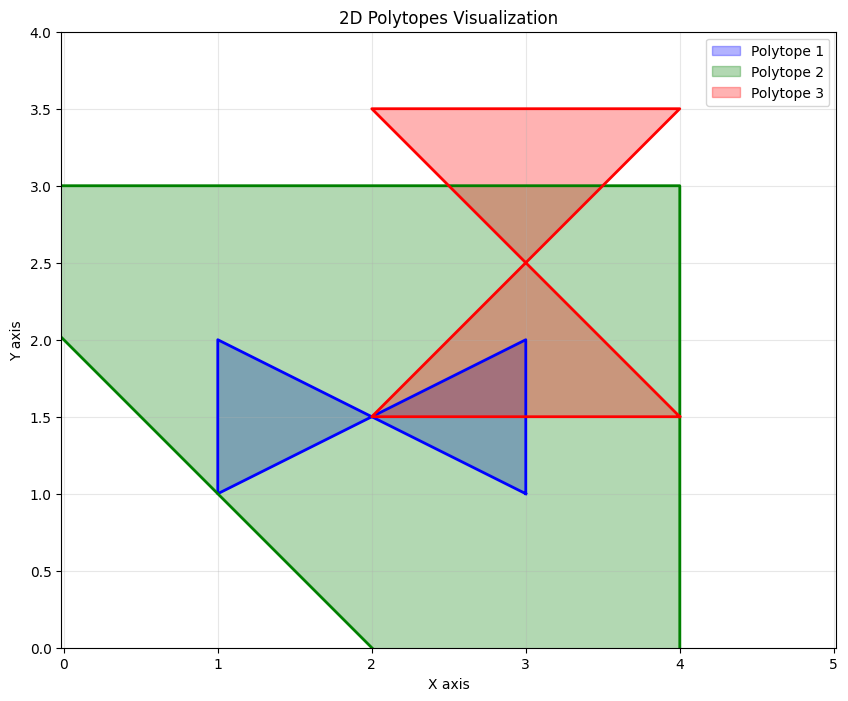

In [11]:
# Function to plot a polytope
def plot_polytope(poly, color, alpha=0.3, label=None):
    # Get vertices of the polytope
    vertices = pc.extreme(poly)
    # Sort vertices to create a proper polygon
    hull = vertices[np.append(np.argsort(np.arctan2(vertices[:, 1], vertices[:, 0])), 0)]
    
    # Plot the filled polygon
    plt.fill(hull[:, 0], hull[:, 1], color=color, alpha=alpha, label=label)
    # Plot the boundary
    plt.plot(hull[:, 0], hull[:, 1], color=color, linewidth=2)

# Create plot
plt.figure(figsize=(10, 8))

# Plot each polytope
plot_polytope(poly1, 'blue', label='Polytope 1')
plot_polytope(poly2, 'green', label='Polytope 2')
plot_polytope(poly3, 'red', label='Polytope 3')

# Try to compute union (Note: exact union computation might be complex)
# Here we'll show the polytopes overlapping which effectively represents their union
plt.grid(True, alpha=0.3)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Polytopes Visualization')
plt.legend()
plt.axis('equal')  # Make axes equal scale
plt.xlim(0, 5)
plt.ylim(0, 4)
plt.show()

# Polytope Operations

Let's demonstrate various operations with our 2D polytopes:
1. Computing intersections between polytopes
2. Computing unions (where possible)
3. Converting polytopes to intervals along each dimension
4. Checking if points are contained in the polytopes

<class 'polytope.polytope.Polytope'>
<class 'polytope.polytope.Region'>


AttributeError: 'Region' object has no attribute 'vertices'

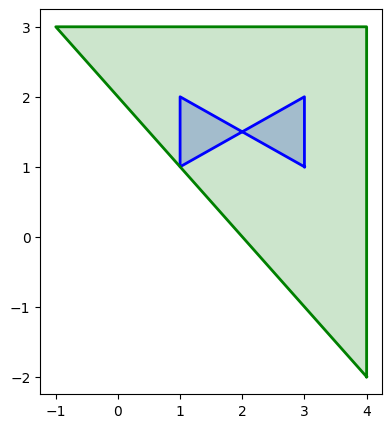

In [ ]:
# Compute intersections between polytopes
intersection_12 = pc.intersect(poly1, poly2)  # Intersection of polytope 1 and 2
intersection_23 = pc.intersect(poly2, poly3)  # Intersection of polytope 2 and 3
intersection_13 = pc.intersect(poly1, poly3)  # Intersection of polytope 1 and 3
union_12 = pc.union(poly1, poly2)  # Union of polytope 1 and 2 (may not be exact)
# Create a new figure to show intersections
plt.figure(figsize=(15, 5))
print(type(intersection_12))
print(type(union_12))
# plot a Region object

# Plot first intersection
plt.subplot(131)
plot_polytope(poly1, 'blue', alpha=0.2, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.2, label='Polytope 2')
plot_polytope(union_12, 'purple', alpha=0.5, label='Intersection')
plt.title('Intersection of Polytopes 1 & 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot second intersection
plt.subplot(132)
plot_polytope(poly2, 'green', alpha=0.2, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.2, label='Polytope 3')
plot_polytope(intersection_23, 'purple', alpha=0.5, label='Intersection')
plt.title('Intersection of Polytopes 2 & 3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot third intersection
plt.subplot(133)
plot_polytope(poly1, 'blue', alpha=0.2, label='Polytope 1')
plot_polytope(poly3, 'red', alpha=0.2, label='Polytope 3')
plot_polytope(intersection_13, 'purple', alpha=0.5, label='Intersection')
plt.title('Intersection of Polytopes 1 & 3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

Polytope 1 intervals:
X: (np.float64(1.0), np.float64(3.0))
Y: (np.float64(1.0), np.float64(2.0))

Polytope 2 intervals:
X: (np.float64(-1.0), np.float64(4.0))
Y: (np.float64(-2.0), np.float64(3.0))

Polytope 3 intervals:
X: (np.float64(2.0), np.float64(3.9999999999999996))
Y: (np.float64(1.5), np.float64(3.5))

Intersection 1&2 intervals:
X: (np.float64(1.0), np.float64(3.0))
Y: (np.float64(1.0), np.float64(2.0))

Intersection 2&3 intervals:
X: (np.float64(2.0), np.float64(3.9999999999999996))
Y: (np.float64(1.5), np.float64(3.0))


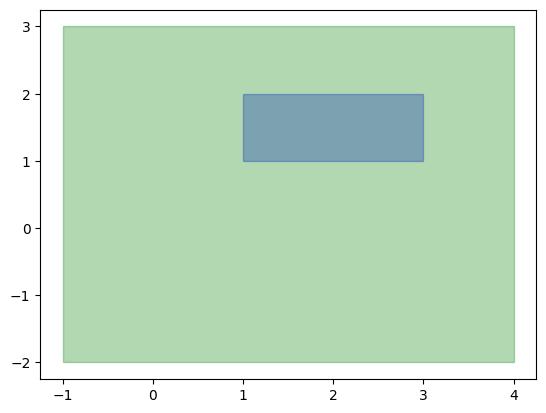

In [20]:
# Function to get intervals (projection) of a polytope along each axis
def get_polytope_intervals(poly):
    # For each dimension, find min and max values using vertices
    vertices = pc.extreme(poly)
    intervals = []
    
    # Get min and max for each dimension
    for dim in range(vertices.shape[1]):
        min_val = np.min(vertices[:, dim])
        max_val = np.max(vertices[:, dim])
        intervals.append((min_val, max_val))
    
    return intervals

# Get intervals for each polytope and their intersections
print("Polytope 1 intervals:")
intervals1 = get_polytope_intervals(poly1)
print("X:", intervals1[0])
print("Y:", intervals1[1])

print("\nPolytope 2 intervals:")
intervals2 = get_polytope_intervals(poly2)
print("X:", intervals2[0])
print("Y:", intervals2[1])

print("\nPolytope 3 intervals:")
intervals3 = get_polytope_intervals(poly3)
print("X:", intervals3[0])
print("Y:", intervals3[1])

print("\nIntersection 1&2 intervals:")
intervals12 = get_polytope_intervals(intersection_12)
print("X:", intervals12[0])
print("Y:", intervals12[1])

print("\nIntersection 2&3 intervals:")
intervals23 = get_polytope_intervals(intersection_23)
print("X:", intervals23[0])
print("Y:", intervals23[1])
# plot intervals as rectangles on a 2D plot
plt.Figure(figsize=(10, 8))
# Plot each polytope's intervals along with the polytopes

plt.fill([intervals1[0][0], intervals1[0][1], intervals1[0][1], intervals1[0][0]], 
         [intervals1[1][0], intervals1[1][0], intervals1[1][1], intervals1[1][1]], 
         color='blue', alpha=0.3, label='Polytope 1 Intervals')
plt.fill([intervals2[0][0], intervals2[0][1], intervals2[0][1], intervals2[0][0]],
         [intervals2[1][0], intervals2[1][0], intervals2[1][1], intervals2[1][1]],
         color='green', alpha=0.3, label='Polytope 2 Intervals')

Point containment test:

Testing point (2, 1.5):
In Polytope 1: True
In Polytope 2: True
In Polytope 3: True

Testing point (1.5, 1.5):
In Polytope 1: True
In Polytope 2: True
In Polytope 3: False

Testing point (3.5, 2.5):
In Polytope 1: True
In Polytope 2: True
In Polytope 3: True

Testing point (0.5, 0.5):
In Polytope 1: False
In Polytope 2: False
In Polytope 3: False


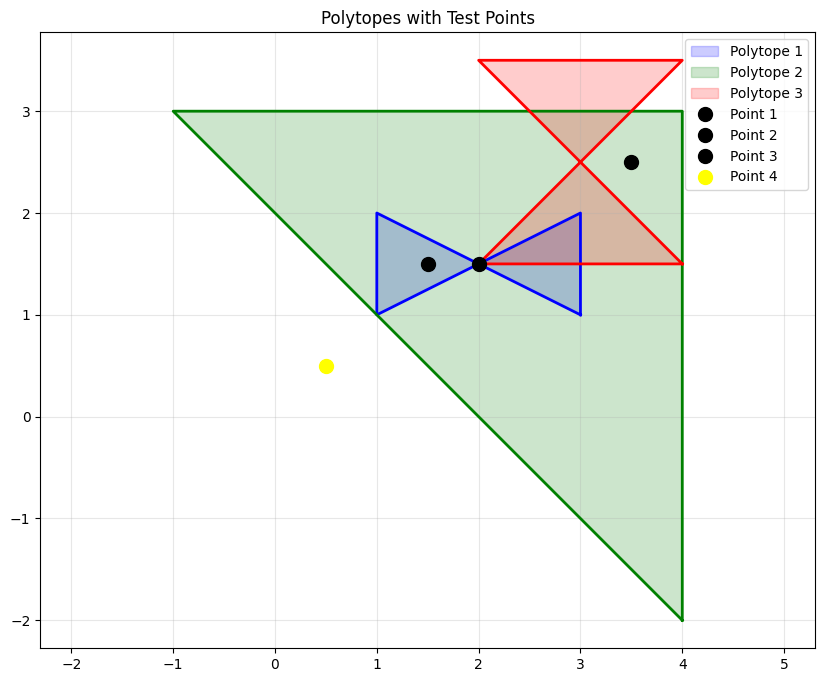

In [17]:
# Demonstrate point containment
test_points = [
    (2, 1.5),  # Should be in multiple polytopes
    (1.5, 1.5),  # Should be in polytope 1 and 2
    (3.5, 2.5),  # Should be in polytope 2 and 3
    (0.5, 0.5),  # Should be outside all polytopes
]

print("Point containment test:")
for point in test_points:
    print(f"\nTesting point {point}:")
    x, y = point
    point_array = np.array(point)
    
    # Check each polytope
    in_poly1 = poly1.contains(point_array).any()
    in_poly2 = poly2.contains(point_array).any()
    in_poly3 = poly3.contains(point_array).any()
    
    print(f"In Polytope 1: {in_poly1}")
    print(f"In Polytope 2: {in_poly2}")
    print(f"In Polytope 3: {in_poly3}")

# Visualize test points
plt.figure(figsize=(10, 8))
plot_polytope(poly1, 'blue', alpha=0.2, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.2, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.2, label='Polytope 3')

# Plot test points with different colors based on containment
for i, (x, y) in enumerate(test_points):
    point_array = np.array([x, y])
    color = 'yellow'
    if any([poly1.contains(point_array).any(), 
            poly2.contains(point_array).any(), 
            poly3.contains(point_array).any()]):
        color = 'black'
    plt.plot(x, y, 'o', color=color, markersize=10, label=f'Point {i+1}')

plt.title('Polytopes with Test Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Plotting Union of Polytopes

We'll demonstrate two approaches to visualize the union of polytopes:
1. Simple overlay with transparency to show the combined region
2. Computing and plotting the convex hull of the combined vertices (note: this is an over-approximation of the union)

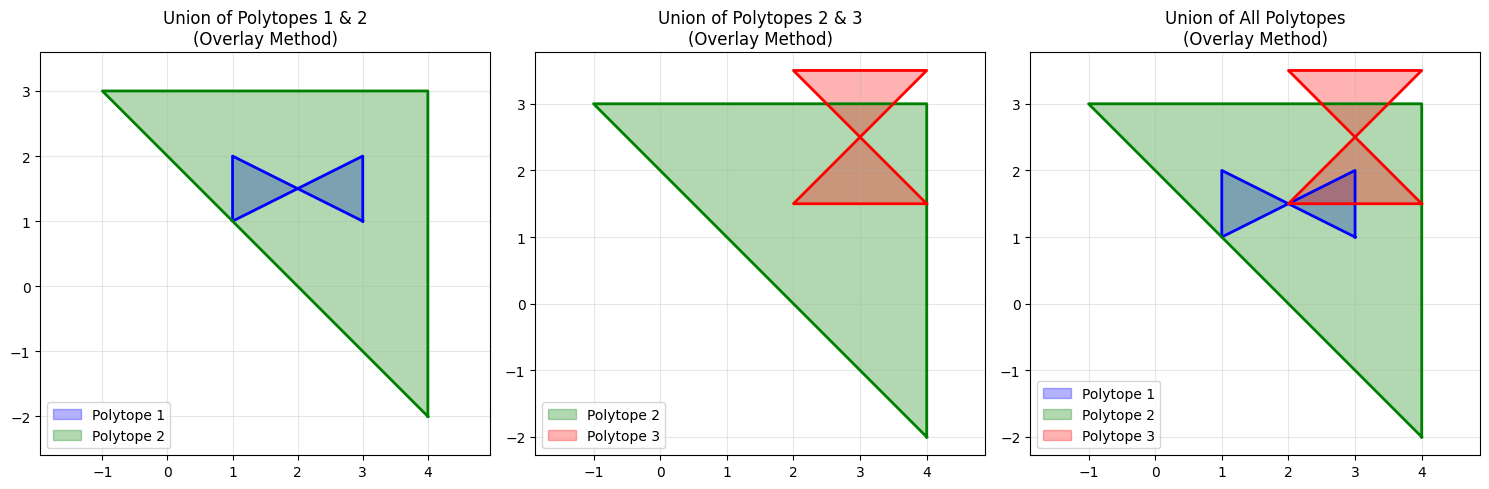

In [23]:
# Method 1: Simple overlay of polytopes
plt.figure(figsize=(15, 5))

# First subplot: Union of polytopes 1 and 2
plt.subplot(131)
plot_polytope(poly1, 'blue', alpha=0.3, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.3, label='Polytope 2')
plt.title('Union of Polytopes 1 & 2\n(Overlay Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Second subplot: Union of polytopes 2 and 3
plt.subplot(132)
plot_polytope(poly2, 'green', alpha=0.3, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.3, label='Polytope 3')
plt.title('Union of Polytopes 2 & 3\n(Overlay Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Third subplot: Union of all polytopes
plt.subplot(133)
plot_polytope(poly1, 'blue', alpha=0.3, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.3, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.3, label='Polytope 3')
plt.title('Union of All Polytopes\n(Overlay Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

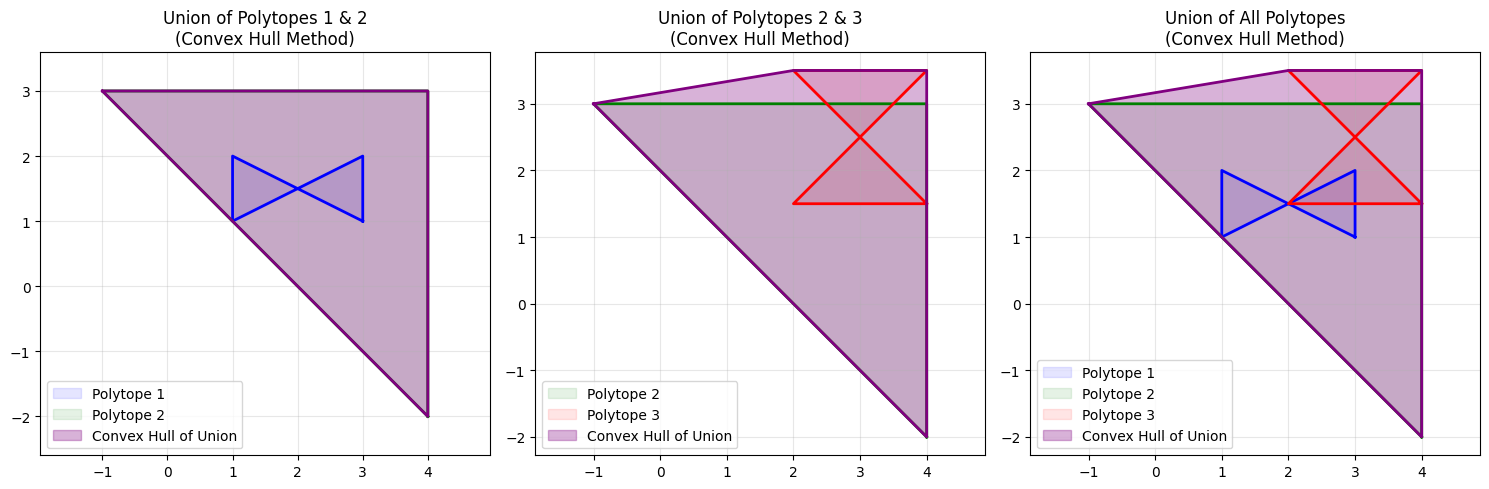

In [24]:
# Method 2: Computing convex hull of combined vertices
from scipy.spatial import ConvexHull

def plot_polytope_union_hull(poly1, poly2, color='purple', alpha=0.3, label=None):
    # Get vertices of both polytopes
    vertices1 = pc.extreme(poly1)
    vertices2 = pc.extreme(poly2)
    
    # Combine vertices
    combined_vertices = np.vstack((vertices1, vertices2))
    
    # Compute convex hull
    hull = ConvexHull(combined_vertices)
    
    # Get hull vertices in order
    hull_vertices = combined_vertices[hull.vertices]
    
    # Plot filled polygon
    plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], 
            color=color, alpha=alpha, label=label)
    # Plot boundary
    plt.plot(np.append(hull_vertices[:, 0], hull_vertices[0, 0]),
             np.append(hull_vertices[:, 1], hull_vertices[0, 1]),
             color=color, linewidth=2)

# Create plots using convex hull method
plt.figure(figsize=(15, 5))

# First subplot: Union of polytopes 1 and 2
plt.subplot(131)
plot_polytope(poly1, 'blue', alpha=0.1, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.1, label='Polytope 2')
plot_polytope_union_hull(poly1, poly2, 'purple', label='Convex Hull of Union')
plt.title('Union of Polytopes 1 & 2\n(Convex Hull Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Second subplot: Union of polytopes 2 and 3
plt.subplot(132)
plot_polytope(poly2, 'green', alpha=0.1, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.1, label='Polytope 3')
plot_polytope_union_hull(poly2, poly3, 'purple', label='Convex Hull of Union')
plt.title('Union of Polytopes 2 & 3\n(Convex Hull Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Third subplot: Union of all polytopes
plt.subplot(133)
plot_polytope(poly1, 'blue', alpha=0.1, label='Polytope 1')
plot_polytope(poly2, 'green', alpha=0.1, label='Polytope 2')
plot_polytope(poly3, 'red', alpha=0.1, label='Polytope 3')
# Compute hull of all vertices
vertices1 = pc.extreme(poly1)
vertices2 = pc.extreme(poly2)
vertices3 = pc.extreme(poly3)
combined_vertices = np.vstack((vertices1, vertices2, vertices3))
hull = ConvexHull(combined_vertices)
hull_vertices = combined_vertices[hull.vertices]
plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], 
         color='purple', alpha=0.3, label='Convex Hull of Union')
plt.plot(np.append(hull_vertices[:, 0], hull_vertices[0, 0]),
         np.append(hull_vertices[:, 1], hull_vertices[0, 1]),
         color='purple', linewidth=2)
plt.title('Union of All Polytopes\n(Convex Hull Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Working with Regions

A Region in the polytope library represents a non-convex set that is composed of multiple polytopes. We'll demonstrate:
1. Creating a Region from multiple polytopes
2. Plotting the Region with different visualization options
3. Creating and plotting a more complex Region with holes

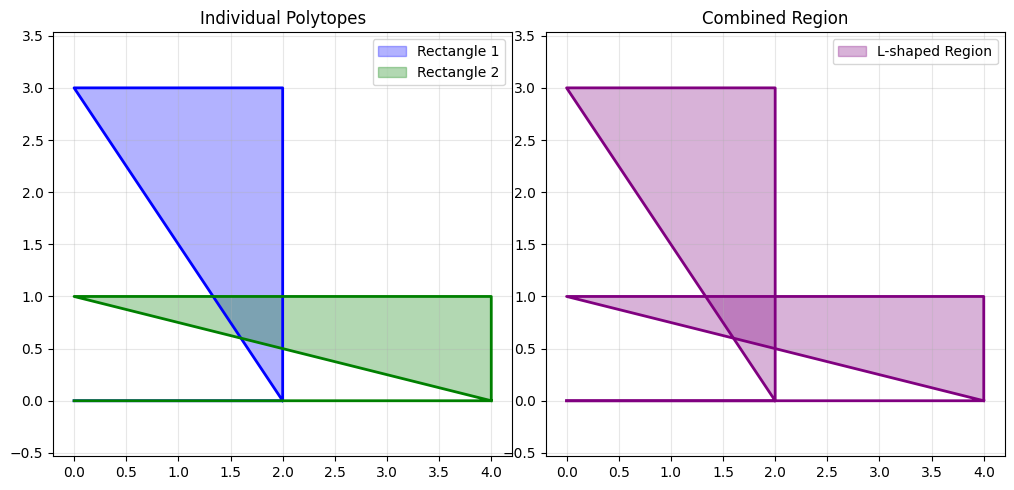

In [25]:
# Create a few simple polytopes for demonstration
# L-shaped region made of two rectangles
rect1 = pc.box2poly([[0, 2], [0, 3]])  # Vertical rectangle
rect2 = pc.box2poly([[0, 4], [0, 1]])  # Horizontal rectangle

# Create a region from these polytopes
L_region = pc.Region([rect1, rect2])

# Function to plot a region
def plot_region(region, color='blue', alpha=0.3, label=None):
    for poly in region.list_poly:
        vertices = pc.extreme(poly)
        hull = vertices[np.append(np.argsort(np.arctan2(vertices[:, 1], vertices[:, 0])), 0)]
        plt.fill(hull[:, 0], hull[:, 1], color=color, alpha=alpha, label=label if label else None)
        plt.plot(hull[:, 0], hull[:, 1], color=color, linewidth=2)
        label = None  # Only show label once in legend

# Create plot
plt.figure(figsize=(10, 5))

# First subplot: Show individual polytopes
plt.subplot(121)
plot_polytope(rect1, 'blue', alpha=0.3, label='Rectangle 1')
plot_polytope(rect2, 'green', alpha=0.3, label='Rectangle 2')
plt.title('Individual Polytopes')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

# Second subplot: Show as a single region
plt.subplot(122)
plot_region(L_region, 'purple', alpha=0.3, label='L-shaped Region')
plt.title('Combined Region')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

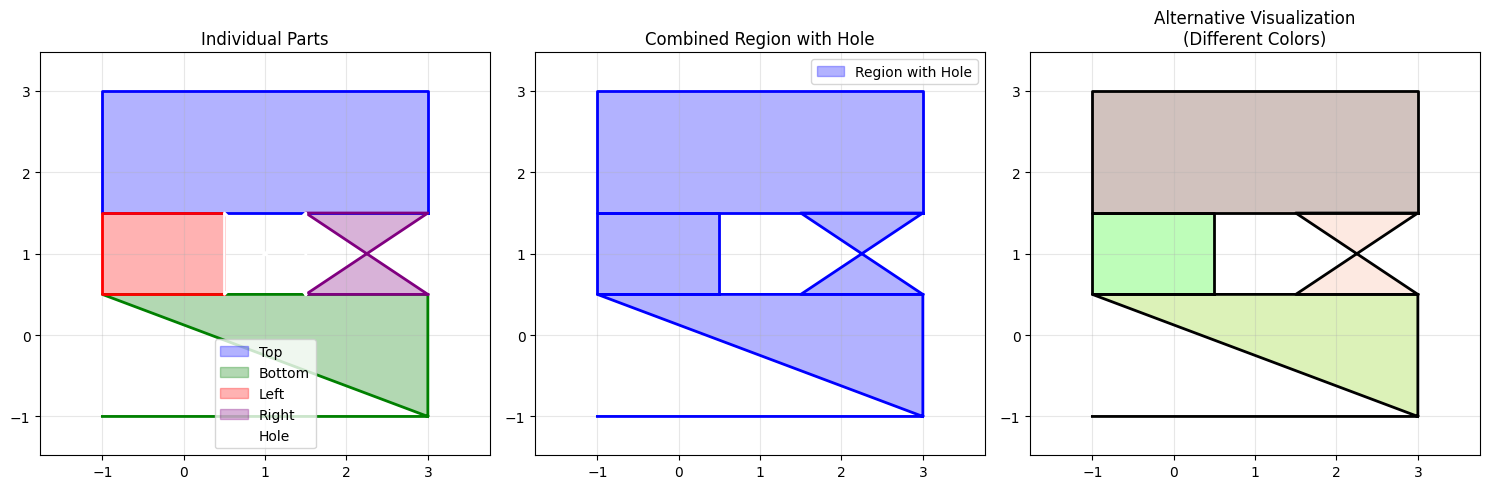

In [26]:
# Create a more complex region with a hole
# Outer square
outer = pc.box2poly([[-1, 3], [-1, 3]])

# Inner square (hole)
inner = pc.box2poly([[0.5, 1.5], [0.5, 1.5]])

# Create polytopes for the region with hole
# We'll create four rectangles that form a square with a hole
top = pc.box2poly([[-1, 3], [1.5, 3]])     # Top rectangle
bottom = pc.box2poly([[-1, 3], [-1, 0.5]])  # Bottom rectangle
left = pc.box2poly([[-1, 0.5], [0.5, 1.5]]) # Left rectangle
right = pc.box2poly([[1.5, 3], [0.5, 1.5]]) # Right rectangle

# Create region from these polytopes
holey_region = pc.Region([top, bottom, left, right])

# Plot the complex region
plt.figure(figsize=(15, 5))

# First subplot: Show individual parts
plt.subplot(131)
plot_polytope(top, 'blue', alpha=0.3, label='Top')
plot_polytope(bottom, 'green', alpha=0.3, label='Bottom')
plot_polytope(left, 'red', alpha=0.3, label='Left')
plot_polytope(right, 'purple', alpha=0.3, label='Right')
plot_polytope(inner, 'white', alpha=1, label='Hole')
plt.title('Individual Parts')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

# Second subplot: Show as a single region
plt.subplot(132)
plot_region(holey_region, 'blue', alpha=0.3, label='Region with Hole')
plt.title('Combined Region with Hole')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

# Third subplot: Show with different style
plt.subplot(133)
for poly in holey_region.list_poly:
    vertices = pc.extreme(poly)
    hull = vertices[np.append(np.argsort(np.arctan2(vertices[:, 1], vertices[:, 0])), 0)]
    plt.fill(hull[:, 0], hull[:, 1], 
             color=np.random.rand(3,), # Random color
             alpha=0.3)
    plt.plot(hull[:, 0], hull[:, 1], 'k-', linewidth=2) # Black boundaries
plt.title('Alternative Visualization\n(Different Colors)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()